# Analyze Social Node Structure 

Perform following structural analysis

    1. Get Egonet for top 10 Social Score nodes with diameter 3 
    2. Get list of nodes visited by random walk from 
    3. Perform k-core decomposition to identify key nodes check if top 10 social score nodes are in the list 
  

In [21]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import csv 

from datetime import datetime
from matplotlib.pyplot import loglog 

from modifiedSocialScore import GenerateGraph, GenerateDirectedNxGraph, GeneratePrunedDirectedGraph

%matplotlib inline

In [22]:
#
# Load adjacency list as a pandas dataframe 
#
df, _ = GenerateGraph(filename='out.dnc-temporalGraph.csv')

In [23]:
#
# Build a networkx directed multigraph 
#   - Edge represents src sent an email to destination 
#
GNx = GenerateDirectedNxGraph(df)

In [24]:
# 
# Build an networkx undirected graph of nodes that have exchanged more than 4 emails 
#
uGNx = GeneratePrunedDirectedGraph(GNx, N=0)

## Egonet analysis of top N nodes ranked based on social score... 

In [25]:
#
# Average shortest path length 
#
connected_components = sorted(nx.connected_components(uGNx), key=len, reverse=True)

# Select the largest connected component
Gc = uGNx.subgraph(connected_components[0])

# Compute the average shortest path length
average_shortest_path = nx.average_shortest_path_length(Gc)

print("Average Shortest Path in email network:", average_shortest_path)


Average Shortest Path in email network: 3.369467930254886


In [35]:
#
# Load social score nodes 
#
socialNodes = list()
topN = 20

with open('socialScore_unpruned.txt', 'r') as fd:
    reader = csv.reader(fd, delimiter='\t')            
    for row in reader:
        socialNodes.append((row[0], row[1]))  
        
nodes = [ int(node) for (node, _) in socialNodes[:topN]]

In [36]:
# 
# Compute Egnonet for top 50 nodes based on Social Score 
#
egoNetworks = dict()
egoNetNodes = dict()

for index, (node, _) in enumerate(socialNodes[:topN]):
    egoNetworks[index] = nx.ego_graph(uGNx, int(node), radius=1, undirected=True)   

    #
    # Generate list of egonet Nodes for each social scode node 
    #
    egoNetNodes[index] = set(egoNetworks[index].nodes)
       

In [37]:
overlapFractions = list()
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        common_nodes = egoNetNodes[i].intersection(egoNetNodes[j])
        min_nodes = min(len(egoNetNodes[i]), len(egoNetNodes[j]))
        frac = float(len(common_nodes))/float(min_nodes)
        overlapFractions.append((nodes[i],nodes[j], frac))

overlapFractions.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)

for src, dst, frac in overlapFractions:
    if (frac >= 0.5):
        print("Nodes %r, %r: overlap: %r" % (src, dst, frac))

print("\n")
for n, s in socialNodes[:topN]:
    print("Node: %r, social score: %r" % (n,s))
   

Nodes 999, 1894: overlap: 0.9142857142857143
Nodes 511, 1369: overlap: 0.9066666666666666
Nodes 999, 1522: overlap: 0.9
Nodes 1998, 1894: overlap: 0.8857142857142857
Nodes 1874, 1522: overlap: 0.875
Nodes 999, 1278: overlap: 0.8620689655172413
Nodes 1874, 1894: overlap: 0.8571428571428571
Nodes 1874, 411: overlap: 0.8536585365853658
Nodes 1874, 1258: overlap: 0.853448275862069
Nodes 1998, 1522: overlap: 0.85
Nodes 1874, 1278: overlap: 0.8448275862068966
Nodes 1580, 737: overlap: 0.8292682926829268
Nodes 1258, 411: overlap: 0.8292682926829268
Nodes 511, 411: overlap: 0.8292682926829268
Nodes 1278, 1894: overlap: 0.8285714285714286
Nodes 1874, 852: overlap: 0.828125
Nodes 999, 1974: overlap: 0.82
Nodes 999, 411: overlap: 0.8048780487804879
Nodes 1974, 1894: overlap: 0.8
Nodes 1874, 1974: overlap: 0.8
Nodes 1258, 1894: overlap: 0.8
Nodes 999, 1998: overlap: 0.796875
Nodes 1874, 999: overlap: 0.794392523364486
Nodes 1874, 1369: overlap: 0.7866666666666666
Nodes 1258, 1522: overlap: 0.775
N

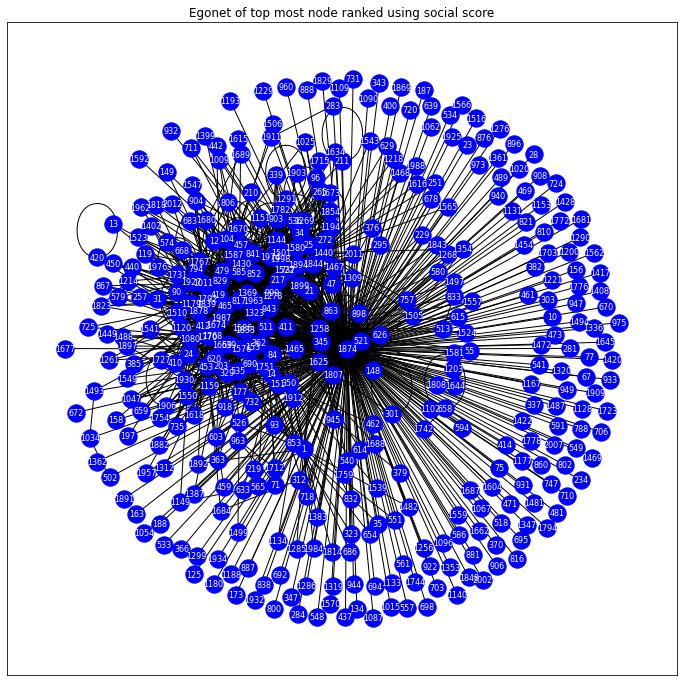

In [38]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of top most node ranked using social score")
nx.draw_networkx(egoNetworks[0], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()



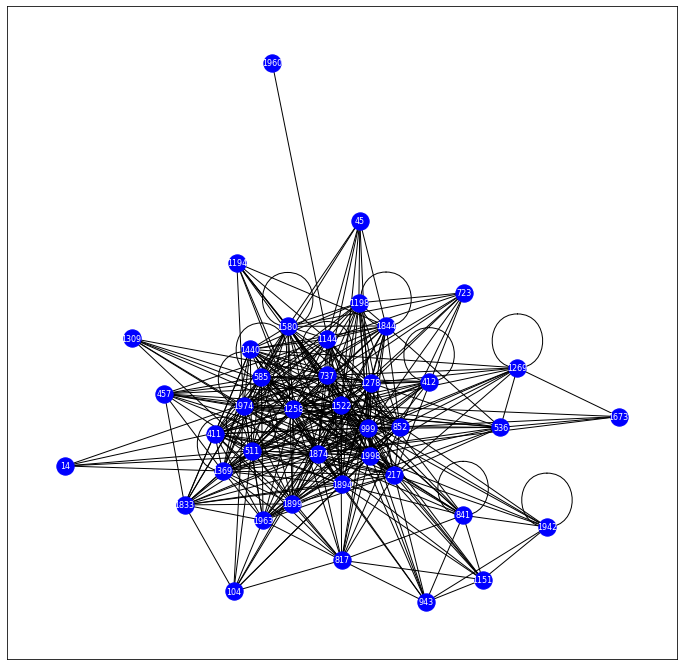

In [39]:
#
# Plot EgoNet of last node in top N Nodes ranked by social score 
#
plt.figure(figsize=(12,12))
nx.draw_networkx(egoNetworks[topN-1], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()

## k-core decomposition 

Analyze DNC email network. Identify central nodes in the network based on k-core decomposition 


Number of nodes in k=17 k-Core network: 23


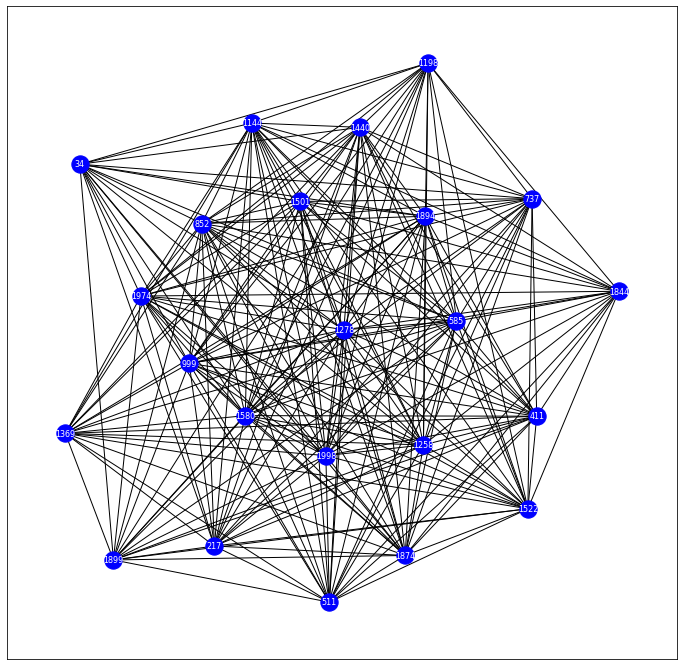

In [41]:
k = 17
uGNx.remove_edges_from(nx.selfloop_edges(uGNx))
k_core_graph = nx.k_core(uGNx, k=k)
print("Number of nodes in k=%d k-Core network: %d" % (k, nx.number_of_nodes(k_core_graph)))
plt.figure(figsize=(12,12))
nx.draw_networkx(k_core_graph, node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()

In [42]:
k_core_nodes = list(k_core_graph.nodes)
k_core_node_set = set(k_core_nodes)
tn = 20
nodes = [ int(node) for (node, _) in socialNodes[:tn]]
social_node_set = set(nodes)
common = social_node_set.intersection(k_core_node_set)
print("k=10 core network has total: %d nodes, %d nodes are common with top %d social nodes" % (len(k_core_nodes),\
                                                                                               len(common),\
                                                                                               tn))
print("Nodes not in k-core: %r" % (social_node_set - k_core_node_set))
print("Social nodes in k=10 core network: %r" % common)

k=10 core network has total: 23 nodes, 16 nodes are common with top 20 social nodes
Nodes not in k-core: {453, 1839, 1669, 1159}
Social nodes in k=10 core network: {1440, 737, 1894, 999, 585, 1258, 1580, 1998, 1874, 1522, 852, 1974, 1369, 411, 1278, 511}


In [43]:
egoNetDistribution = list()
totalEgoNetSize = 0.0
for i in range(len(nodes)):
    egoNetSize = len(list(egoNetworks[i].nodes))
    egoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    
avgEgoNetSize = totalEgoNetSize/len(nodes)
print("Average Egonet size: %r, (Max:%r, min:%r)" % (avgEgoNetSize, max(egoNetDistribution), min(egoNetDistribution)))


Average Egonet size: 117.85, (Max:403, min:35)


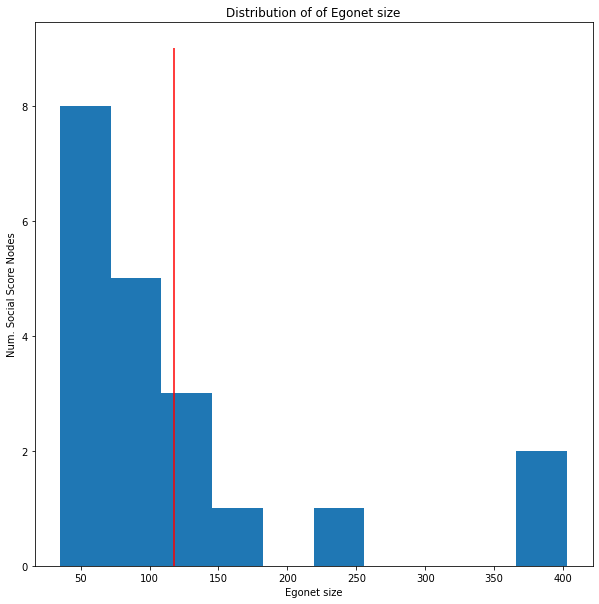

In [44]:
plt.figure(figsize=(10,10))
plt.title("Distribution of of Egonet size")
plt.xlabel('Egonet size')
plt.ylabel('Num. Social Score Nodes')
plt.vlines(avgEgoNetSize, 0, 9, color='r')
plt.hist(egoNetDistribution)
plt.show()

# CELF Node analysis

In [45]:
celfNodes = [ 453, 246, 1952, 1144, 1701, 547, 1377, 1907, 278, 1889, 1874, 1953, 115, 1966, 795, 1803, 1805, 2014, 1287, 798 ]                                     
celfNodeSet = set(celfNodes)

In [46]:
celfNodesInKCore = celfNodeSet.intersection(k_core_node_set)
celfNodeInSocialNodes = celfNodeSet.intersection(social_node_set)

In [47]:
print("CELF nodes in k-core k=10 %r" % celfNodesInKCore)
print("CELF nodes in top N nodes ranked by social score %r" % celfNodeInSocialNodes)

CELF nodes in k-core k=10 {1144, 1874}
CELF nodes in top N nodes ranked by social score {1874, 453}


## Betweeness centrality

Average Betweeness Centrality of nodes selected by CELF: 0.032470870510268986


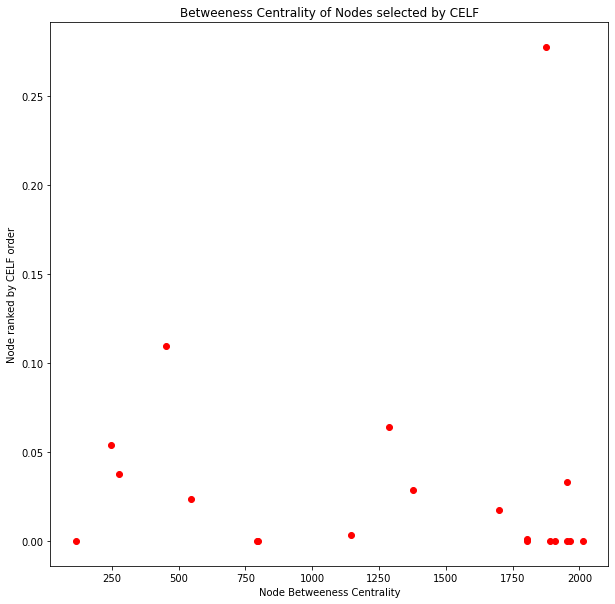

In [48]:
node_between_centrality = nx.betweenness_centrality(uGNx)
celfNodeBetweenCentrality = list()

totalCelfNodeBetweenCentrality = 0.0

y = list()
for n in celfNodes:   
    b = node_between_centrality.get(n, None)
    
    if b == None:
        print("Node %r not found in pruned Graph!" % n)
        continue
        
    celfNodeBetweenCentrality.append(b)
    totalCelfNodeBetweenCentrality += b
    y.append(n)
    
avgCelfNodeBetweenCentrality = totalCelfNodeBetweenCentrality/len(celfNodes)  
print("Average Betweeness Centrality of nodes selected by CELF: %r" % avgCelfNodeBetweenCentrality)

plt.figure(figsize=(10,10))
plt.title("Betweeness Centrality of Nodes selected by CELF")
plt.xlabel("Node Betweeness Centrality")
plt.ylabel("Node ranked by CELF order")
plt.plot(y, celfNodeBetweenCentrality, 'ro')
plt.show()

Average Betweeness Centrality of nodes selected ranked by Social Score: 0.07059158151476777


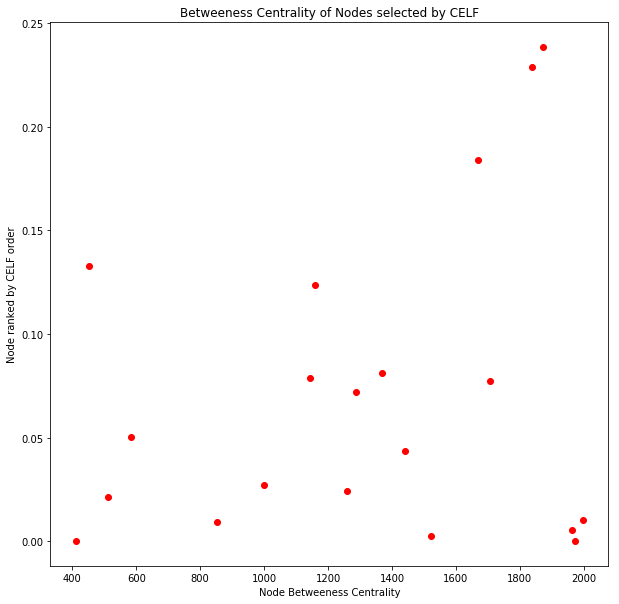

In [22]:
node_between_centrality = nx.betweenness_centrality(uGNx)
socialNodeBetweenCentrality = list()

totalSocialNodeBetweenCentrality = 0.0

y = list()
for n in nodes:   
    b = node_between_centrality.get(n, None)
    
    if b == None:
        print "Node %r not found in undirected Graph!" % n
        continue
        
    socialNodeBetweenCentrality.append(b)
    totalSocialNodeBetweenCentrality += b
    y.append(n)
    
avgSocialNodeBetweenCentrality = totalSocialNodeBetweenCentrality/len(celfNodes)  
print "Average Betweeness Centrality of nodes selected ranked by Social Score: %r" % avgSocialNodeBetweenCentrality

plt.figure(figsize=(10,10))
plt.title("Betweeness Centrality of Nodes selected by CELF")
plt.xlabel("Node Betweeness Centrality")
plt.ylabel("Node ranked by CELF order")
plt.plot(y, socialNodeBetweenCentrality, 'ro')
plt.show()

39264
4384
1891
1891


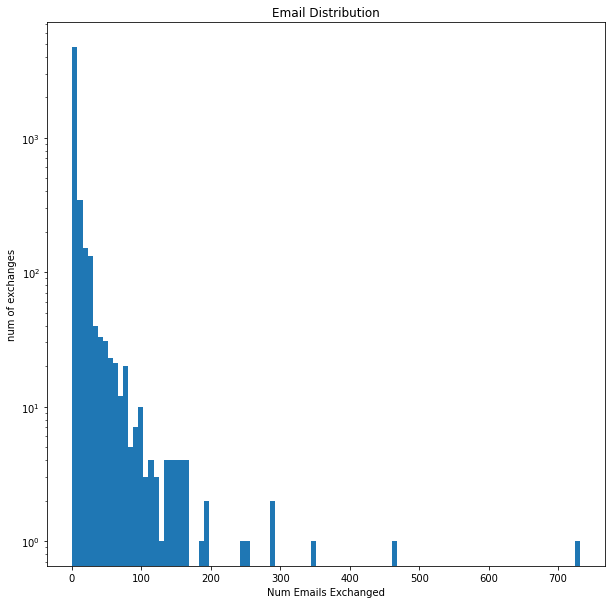

In [50]:
print(GNx.number_of_edges())
print(uGNx.number_of_edges())
print(GNx.number_of_nodes())
print(uGNx.number_of_nodes())

edgeCount = dict()
for edge in GNx.edges():
    if not edgeCount.get(edge, None):
        edgeCount[edge] = 0
    edgeCount[edge] += 1 
        
emailDist= [ v for k, v in edgeCount.items() ]
emailDist.sort(reverse=True)

plt.figure(figsize=(10,10))
plt.title("Email Distribution")
plt.xlabel("Num Emails Exchanged")
plt.ylabel("num of exchanges")
plt.yscale('log')
plt.hist(emailDist,bins=100)
plt.show()


In [51]:
# 
#  Egnonet of nodes picked by CELF
#
egoNetworks = dict()
egoNetNodes = dict()

for index, node in enumerate(celfNodes):
    if not uGNx.has_node(node):
        continue
        
    egoNetworks[node] = nx.ego_graph(uGNx, int(node), radius=1, undirected=True)   

    #
    # Generate list of egonet Nodes for each social scode node 
    #
    egoNetNodes[node] = set(egoNetworks[node].nodes)
       

Average Egonet size: 50.75, (Max:402, min:1)


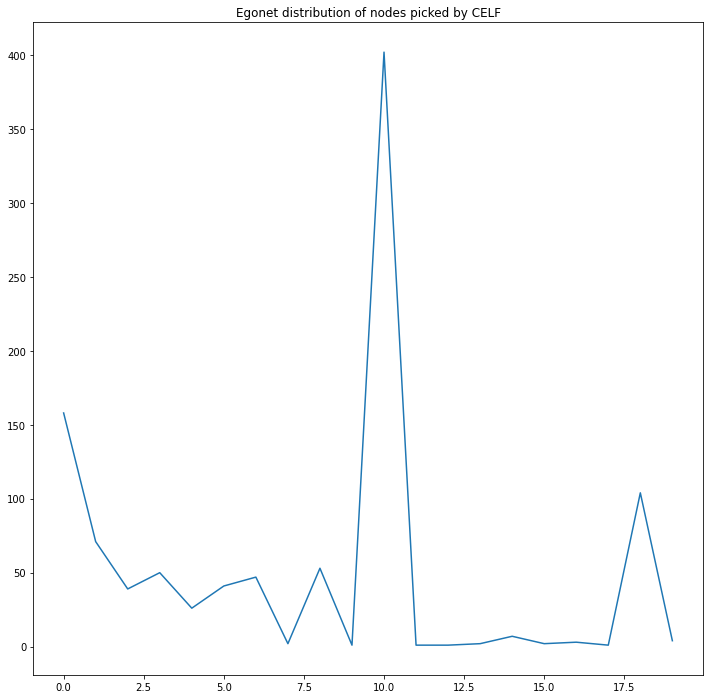

In [53]:
egoNetDistribution = list()
egoNetTuple = list()
totalEgoNetSize = 0.0
for node in egoNetworks.keys():
    egoNetSize = egoNetworks[node].number_of_nodes() - 1
    egoNetDistribution.append(egoNetSize)
    totalEgoNetSize += float(egoNetSize)
    egoNetTuple.append((node, egoNetSize))
    
avgEgoNetSize = totalEgoNetSize/len(egoNetworks)
print("Average Egonet size: %r, (Max:%r, min:%r)" % (avgEgoNetSize, max(egoNetDistribution), min(egoNetDistribution)))


plt.figure(figsize=(12,12))
plt.title("Egonet distribution of nodes picked by CELF")
plt.plot(egoNetDistribution)
plt.show()

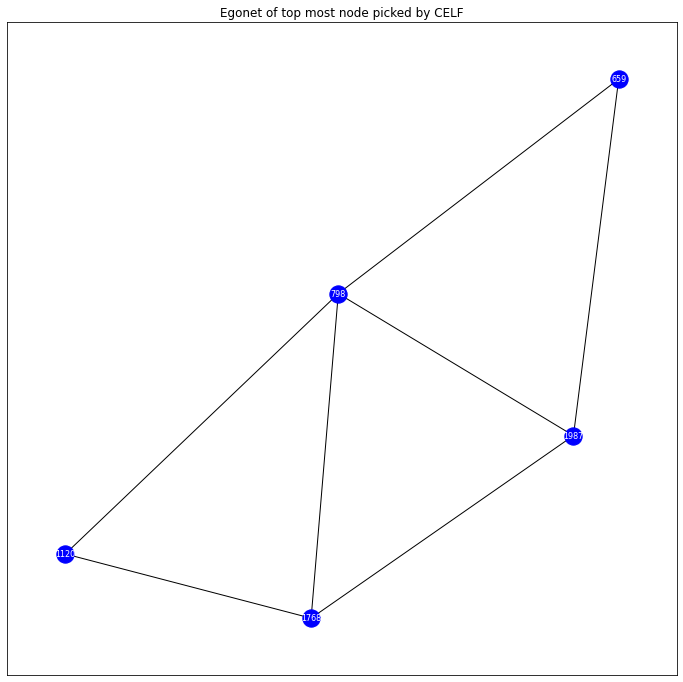

7


In [55]:
# Draw graph

plt.figure(figsize=(12,12))
plt.title("Egonet of top most node picked by CELF")
nx.draw_networkx(egoNetworks[798], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()
print(egoNetworks[798].number_of_edges())


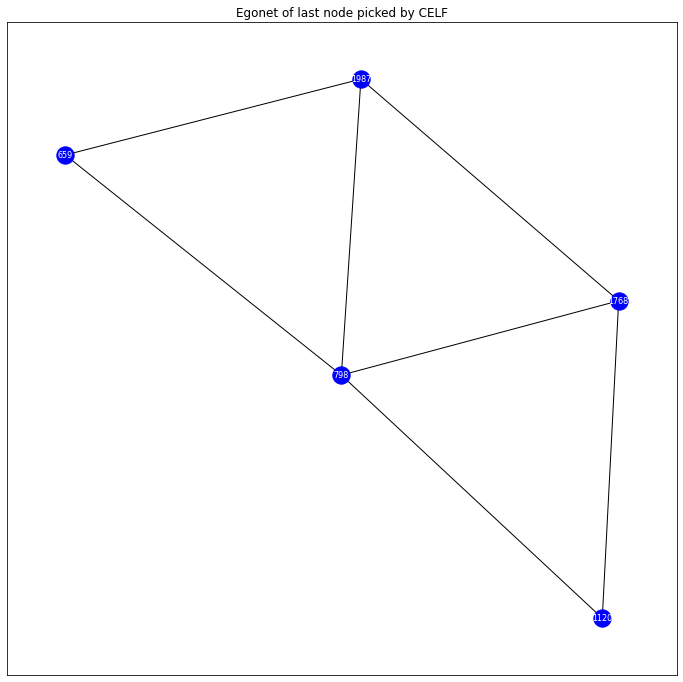

In [56]:
plt.figure(figsize=(12,12))
plt.title("Egonet of last node picked by CELF")
nx.draw_networkx(egoNetworks[798], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()


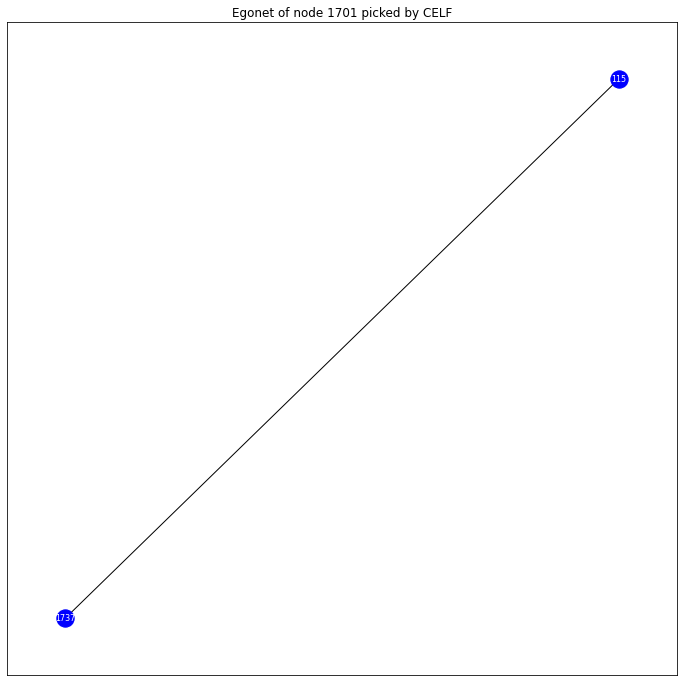

2


In [58]:
plt.figure(figsize=(12,12))
plt.title("Egonet of node 1701 picked by CELF")
nx.draw_networkx(egoNetworks[115], node_color='b', with_labels=True, font_size=8, font_color='w')
plt.show()
print(egoNetworks[115].number_of_nodes())

In [59]:
print(egoNetTuple)

[(453, 158), (246, 71), (1952, 39), (1144, 50), (1701, 26), (547, 41), (1377, 47), (1907, 2), (278, 53), (1889, 1), (1874, 402), (1953, 1), (115, 1), (1966, 2), (795, 7), (1803, 2), (1805, 3), (2014, 1), (1287, 104), (798, 4)]


In [60]:
GNx.degree(1889)

466

In [61]:
x = [1874, 1258, 1669, 999, 511, 852, 585, 1440, 1998, 1278, 1580, 1974, 411, 453, 1159, 1894, 1369, 1839, 1522, 737, 1706, 1144    
, 1287, 1963 ]
x_set = set(x)
social_set = set([ int(node) for (node, _) in socialNodes[:24]])
y = x_set.intersection(social_set)
print(len(y), len(social_set), len(x_set))
print(x_set - y)
print(social_node_set.intersection(celfNodeSet))
print(x_set.intersection(celfNodeSet))

23 24 24
{1963}
{1874, 453}
{1144, 1874, 453, 1287}


In [62]:
G = uGNx.to_undirected()
p = nx.pagerank(uGNx)
k = nx.katz_centrality(uGNx, alpha=0.01)

In [63]:
b = nx.betweenness_centrality(uGNx)

[(1874, 0.1222434085095279), (1669, 0.11311546428675887), (1159, 0.07474923364706841), (453, 0.06436541618987217), (1706, 0.061511979122706645), (1839, 0.059557931503411765), (1258, 0.05678960129264752), (999, 0.054844803325822054), (511, 0.05436232683733908), (585, 0.050037878524779984), (1, 0.049298064097495896), (1287, 0.048037342818758516), (1440, 0.047216872757806526), (1369, 0.045700987889411245), (737, 0.04453589874223486), (1768, 0.042479695328786427), (895, 0.042390883876964776), (852, 0.042147623157685936), (1998, 0.04185679256632458), (1586, 0.041506947643602125)]
[(1669, 0.05755745012999254), (1874, 0.04159278450515561), (1159, 0.02751489621770269), (1, 0.0205403835109533), (1706, 0.019432217723940763), (453, 0.01655282973658803), (246, 0.012522780885635095), (1287, 0.012351246055221723), (1839, 0.011118654478453909), (895, 0.009487119062647261), (1258, 0.00858608392632883), (993, 0.007903312458670304), (1274, 0.007627648545566618), (511, 0.007473262587423171), (1440, 0.007

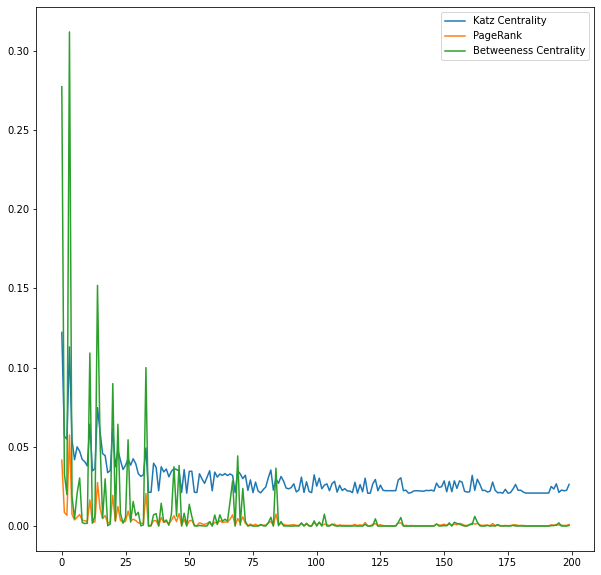

In [65]:
n_list = [(node, v) for node, v in k.items()]
n_list.sort(key=lambda x: x[1], reverse=True)
print(n_list[:20])

np_list = [(node, v) for node, v in p.items()]
np_list.sort(key=lambda x: x[1], reverse=True)
print(np_list[:20])

nodeL = [ int(node) for (node, _) in socialNodes[:200] ]
y = [k[nn] for nn in nodeL ]
yp = [p[nn] for nn in nodeL ]
yb = [b[nn] for nn in nodeL ]

plt.figure(figsize=(10,10))
plt.plot(y)
plt.plot(yp)
plt.plot(yb)
plt.legend(['Katz Centrality', 'PageRank', 'Betweeness Centrality'])
plt.show()